
## Data modeling

Given the following [data-set](https://gist.githubusercontent.com/alephd/e3899eaae0e7869e9c230f6a0fe944e5/raw/deab4f93a9c15224ac118d46533d9ea9700d206a/2019_data_science_test.json).

### generation of 10k rows of new data from the same distribution


> *Simple Method 1* represents the initial idea to make use of statistics for generating new data. As the column features could be generalized by a multivariate normal distribution, new samples could be produced by making use of the means and covariance between columns. However, this induces a shift as illustrated by comparing Figure 1 and 2. <br> <br> 
Therefore, the implementation of a GAN or VAE is preferred for data augmentation. The goal of *Advanced Method 2* is to construct plausible row vectors with thus coherent column features. The implementation of a GAN promotes diversity to mimic the original dataset distribution. <br> <br> 
Inspiration for the GAN network was found on: [RealPython GAN](https://realpython.com/generative-adversarial-networks/#your-first-gan). The latter resource was useful to distinguish this use case from image data. In addition, as optimization is hard to define given the data, the best outlook is to assess the generator by visually comparing Figure 1 and 3. Therefore, dropout and a low learning rate was necessary as a regularization technique to avoid overfitting. <br> <br>
The 10k rows of new data is represented by *generated_samples* in the notebook. Moreover, the trained generator model could be loaded and found under *Model3000* in the folder.

In [ ]:
import requests
import matplotlib.pyplot as plt
import matplotlib.image as img
import torch
from torch import nn
import sklearn as skl
import numpy as np
import seaborn as sns

res = requests.get("https://gist.githubusercontent.com/IdrissMg/695f423af0f0aaffd8d69bc403932c6b/raw/6f3192bbcc328f2aa53ae2faef0cefb825564ea9/data_science_test.json")
data = np.array(res.json())

In [ ]:
print(data.shape)
print(data[:10,:])

(1542, 7)
[[ 0.35550847 -0.16861307 -0.03649862  0.19952643 -0.11887184  0.29424839
  -0.28051336]
 [ 0.4260113  -0.21258807 -0.01852221  0.22457905 -0.15877081  0.32463416
  -0.37767599]
 [ 0.29133138 -0.1376825   0.0477822   0.36069595 -0.26262892  0.36821576
  -0.22965423]
 [ 0.31290507 -0.15962714  0.05445522  0.33733013 -0.2346064   0.2984015
  -0.20969495]
 [ 0.30500781 -0.13593187 -0.01060943  0.28193989 -0.23838613  0.33592651
  -0.22018852]
 [ 0.31491301 -0.14003621  0.00660586  0.275029   -0.18690363  0.33443304
  -0.27883085]
 [ 0.39339591 -0.13173083  0.0158673   0.18128972 -0.15204574  0.3052976
  -0.34210036]
 [ 0.3136345  -0.15933352  0.00958527  0.28161228 -0.1882738   0.30471432
  -0.2638125 ]
 [ 0.33660039 -0.17667822  0.0593603   0.31968113 -0.28692315  0.38236689
  -0.26209681]
 [ 0.3190583  -0.13005376  0.02983905  0.16937195 -0.13130105  0.23831343
  -0.27769289]]


###Figure 1

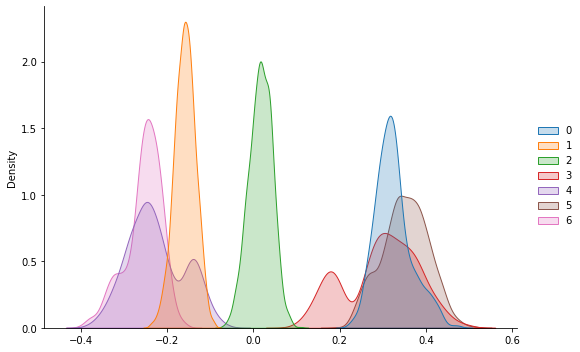

In [ ]:
import seaborn as sns
sns.displot(data, kind='kde', fill=True, height=5, aspect=1.5)

#Simple Method 1: Sampling

**Initial idea: Markov Chain Monte Carlo - Metropolis-Hastings**

In [ ]:
means = data.mean(axis=0)
covariance = np.cov(data, rowvar=False)

In [ ]:
samples = np.random.multivariate_normal(means, covariance, 10000)
print(samples.shape)
print(samples[:10,:])

(10000, 7)
[[ 0.33626665 -0.17408804 -0.00486795  0.16912529 -0.10407322  0.27034855
  -0.3086849 ]
 [ 0.33675242 -0.19039415  0.0503041   0.35893014 -0.30112193  0.37465198
  -0.27871212]
 [ 0.41824638 -0.19131599  0.04359193  0.25656982 -0.22034568  0.35041916
  -0.27021272]
 [ 0.27996414 -0.15483847  0.01980602  0.33237706 -0.26551732  0.37604921
  -0.23902517]
 [ 0.30299599 -0.1742916   0.03047208  0.33826405 -0.23145575  0.39872871
  -0.27380888]
 [ 0.26050593 -0.12657999  0.03301583  0.36293178 -0.28905198  0.37325991
  -0.19397906]
 [ 0.37722582 -0.16658711  0.03518014  0.40010432 -0.28674075  0.43940308
  -0.24465915]
 [ 0.30886798 -0.12840285 -0.02585937  0.21755214 -0.17223267  0.28948178
  -0.24337889]
 [ 0.32091573 -0.1595719   0.01846626  0.38876407 -0.30841827  0.35908006
  -0.21712911]
 [ 0.35564741 -0.16482616  0.05445574  0.37378269 -0.29804182  0.42603875
  -0.25094046]]


##Figure 2

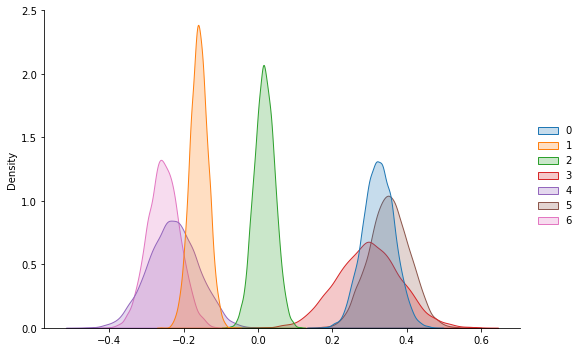

In [ ]:
sns.displot(samples, kind='kde', fill=True, height=5, aspect=1.5)

#Advanced Method 2: GAN

**Data Augmentation: GAN, VAE, Adversarial Training, Transfer Learning**

##Data Preperation

In [ ]:
data_length = data.shape[0]
data_labels = torch.zeros(data_length)
data_set = [(data[i], data_labels[i]) for i in range(data_length)]

In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=True, drop_last=True)

##Discriminator / Generator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(7, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

discriminator = Discriminator()

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(7, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 7),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

##Training

In [ ]:
lr = 0.0001
num_epochs = 3000
loss_function = nn.BCELoss()

In [ ]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [ ]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 7))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples.float())
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 7))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.6838569641113281
Epoch: 0 Loss G.: 0.6781536936759949
Epoch: 10 Loss D.: 0.7053040862083435
Epoch: 10 Loss G.: 0.7063733339309692
Epoch: 20 Loss D.: 0.6946557760238647
Epoch: 20 Loss G.: 0.7296419739723206
Epoch: 30 Loss D.: 0.6903371214866638
Epoch: 30 Loss G.: 0.7603621482849121
Epoch: 40 Loss D.: 0.6651572585105896
Epoch: 40 Loss G.: 0.7088194489479065
Epoch: 50 Loss D.: 0.6719305515289307
Epoch: 50 Loss G.: 0.6579321622848511
Epoch: 60 Loss D.: 0.6827128529548645
Epoch: 60 Loss G.: 0.7027110457420349
Epoch: 70 Loss D.: 0.7314665913581848
Epoch: 70 Loss G.: 0.7409666776657104
Epoch: 80 Loss D.: 0.7093104124069214
Epoch: 80 Loss G.: 0.678391695022583
Epoch: 90 Loss D.: 0.6976849436759949
Epoch: 90 Loss G.: 0.7462604641914368
Epoch: 100 Loss D.: 0.6854257583618164
Epoch: 100 Loss G.: 0.7286328077316284
Epoch: 110 Loss D.: 0.7039243578910828
Epoch: 110 Loss G.: 0.7088630199432373
Epoch: 120 Loss D.: 0.6551353335380554
Epoch: 120 Loss G.: 0.7043726444244385
Epoch: 13

##Data Augmentation



In [ ]:
latent_space_samples = torch.randn(10000, 7)
generated_samples = generator(latent_space_samples)

In [ ]:
print(generated_samples.shape)
print(generated_samples[:10,:])

torch.Size([10000, 7])
tensor([[ 0.3007, -0.1356,  0.0274,  0.3107, -0.2166,  0.3164, -0.2245],
        [ 0.3919, -0.1564, -0.0115,  0.1518, -0.0849,  0.2699, -0.2952],
        [ 0.2858, -0.1492,  0.0156,  0.2896, -0.2343,  0.3361, -0.2331],
        [ 0.2783, -0.1265,  0.0296,  0.2405, -0.2045,  0.2902, -0.2264],
        [ 0.2947, -0.1378, -0.0023,  0.2599, -0.2240,  0.3169, -0.2327],
        [ 0.3672, -0.1675,  0.0294,  0.3068, -0.2411,  0.4107, -0.2809],
        [ 0.3254, -0.1393,  0.0163,  0.3636, -0.2774,  0.3556, -0.2559],
        [ 0.3056, -0.1562,  0.0369,  0.3879, -0.2893,  0.4201, -0.2518],
        [ 0.2818, -0.1690, -0.0059,  0.3600, -0.2820,  0.3740, -0.2024],
        [ 0.3352, -0.1666,  0.0060,  0.3155, -0.2600,  0.3813, -0.2327]],
       grad_fn=<SliceBackward0>)


In [ ]:
generated_samples = generated_samples.detach().numpy()

###Figure 3

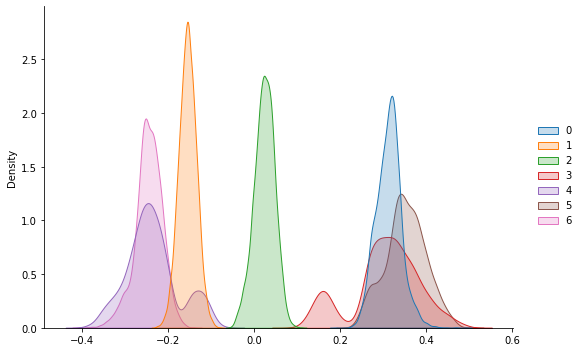

In [ ]:
sns.displot(generated_samples, kind='kde', fill=True, height=5, aspect=1.5)

##Model Saving

In [ ]:
import os
from google.colab import drive
MOUNTPOINT = '/content/gdrive'
MODEL_DIR = os.path.join(MOUNTPOINT, 'MyDrive/GAN/Models/Model3000')
drive.mount(MOUNTPOINT)

Mounted at /content/gdrive


In [ ]:
torch.save(generator.state_dict(), MODEL_DIR)

In [ ]:
generator.load_state_dict(torch.load(MODEL_DIR))

<All keys matched successfully>